<a href="https://colab.research.google.com/github/blackfly19/Segmentation-Model/blob/master/segmenation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
import keras
from keras.applications import vgg16 
from keras.models import load_model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import Concatenate
from keras.models import Model
from keras.layers import Cropping2D, add, Reshape, Activation
%matplotlib inline 


Using TensorFlow backend.


In [ ]:
X = np.zeros((95,256,256,3))
y = np.zeros((95,256,256,1))
width = int(256)
height = int(256)
dim = (width,height)
X_train = [cv.imread(file) for file in glob.glob("drive/My Drive/X_train/*.png")]
y_train = [cv.imread(file) for file in glob.glob("drive/My Drive/y_train/*.png")]
for i in range(0,95):

    gray = cv.cvtColor(y_train[i],cv.COLOR_BGR2GRAY)
    ret,threshold = cv.threshold(gray,100,255,cv.THRESH_BINARY)
    X_train[i] = cv.resize(X_train[i],dim,interpolation = cv.INTER_AREA)
    y[i,:,:,0] = cv.resize(threshold,dim,interpolation = cv.INTER_AREA)
    X_train[i] = X_train[i]/255
    y[i,:,:,0] = y[i,:,:,0]/255
    X[i,:,:,:] = X_train[i]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


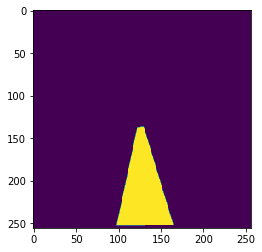

In [ ]:
plt.imshow(y[1,:,:,0],interpolation = 'nearest')
print(y[1,:,:,0])
plt.show()

In [ ]:
def FCN8_helper(nClasses, input_height, input_width):


    img_input = Input(shape=(input_height, input_width, 3))

    model = vgg16.VGG16(include_top=False,weights='imagenet', input_tensor=img_input,pooling=None,classes=1000)
    assert isinstance(model, Model)

    X = Conv2D(filters=4096,kernel_size=(7,7),padding="same",activation="relu",name="fc6")(model.output)
    X = Dropout(rate=0.5)(X)
    X = Conv2D(filters=4096,kernel_size=(1,1),padding="same",activation="relu",name="fc7")(X)
    X = Dropout(rate=0.5)(X)

    X = Conv2D(filters=nClasses, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal",name="score_fr")(X)

    X = Conv2DTranspose(filters=nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None,name="score2")(X)

    fcn8 = Model(inputs=img_input, outputs=X)

    return fcn8


In [ ]:
def FCN8(nClasses, input_height, input_width):

    fcn8 = FCN8_helper(nClasses, input_height, input_width)

    skip_con1 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",name="score_pool4")(fcn8.get_layer("block4_pool").output)
    Summed = add(inputs=[skip_con1, fcn8.output])

    x = Conv2DTranspose(nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None,name="score4")(Summed)

    skip_con2 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",name="score_pool3")(fcn8.get_layer("block3_pool").output)
    Summed2 = add(inputs=[skip_con2, x])

    Up = Conv2DTranspose(nClasses, kernel_size=(194,194), strides=(2,2),padding="valid", activation=None, name="upsample")(Summed2)

    Up = Activation("sigmoid")(Up)

    mymodel = Model(inputs=fcn8.input, outputs=Up)

    return mymodel

In [ ]:
fcn_seg_model = FCN8(1,256,256)
fcn_seg_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
fcn_seg_model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])


In [ ]:
fcn_seg_model.fit(X,y,epochs = 20,batch_size = 8,shuffle = True)

In [ ]:
#fcn_seg_model.save("drive/My Drive/FCN8_predict.h5")
#fcn_seg_model.save("unet_seg_model.h5")
#fcn_seg_model.save("drive/My Drive/unet_seg_model.h5")

In [ ]:
fcn_seg_model = load_model("drive/My Drive/FCN8_(4*4)_new_predict.h5")

In [ ]:
x = np.zeros((1,256,256,3))
y_test = np.zeros((1,256,256,1))
img = cv.imread('test.jpg',1)
img = cv.resize(img,(256,256),interpolation = cv.INTER_AREA)
img = img/255
x[0,:,:,:] = X_train[70]
y_test = fcn_seg_model.predict(x)

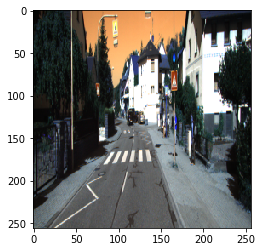

In [ ]:
plt.imshow(x[0],interpolation = 'nearest')
plt.show()

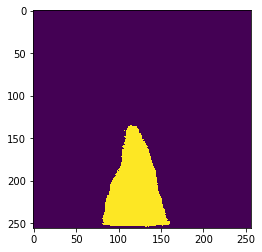

[[0.01024994 0.01620862 0.01635107 ... 0.00582641 0.00896552 0.00792009]
 [0.00735337 0.01152849 0.02265248 ... 0.01231647 0.00822616 0.00525054]
 [0.01257679 0.00996923 0.01156837 ... 0.00529855 0.00421196 0.00578484]
 ...
 [0.10582244 0.11265308 0.10704133 ... 0.01977712 0.01730546 0.01883137]
 [0.09976006 0.11083683 0.10757861 ... 0.02855325 0.02083391 0.03276518]
 [0.10671124 0.09614637 0.10449666 ... 0.0175105  0.01943916 0.01932743]]


In [ ]:
y_test = y_test.reshape((256,256))
ret,threshold = cv.threshold(y_test,0.5,255,cv.THRESH_BINARY)
plt.imshow(threshold,interpolation = 'nearest')
plt.show()
print(y_test)

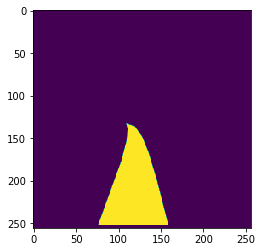

In [ ]:
plt.imshow(y[70,:,:,0],interpolation = 'nearest')
plt.show()